In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, accuracy_plot, calc_metrics
import shap

### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

In [4]:
# set up
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
tgt = f'{prop}_log1p'

# model
pathm = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/model_rf.{prop}_ccc.joblib'
model = joblib.load(pathm)
# model.n_jobs=90

# covariates
pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
covs = read_features(pathc) 

# data
train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',low_memory=False)
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',low_memory=False)
test = test.dropna(subset=covs+[tgt],how='any')

av = 'cropland.extent_glad.interpolate_p_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20240604'
test.loc[test[av]>0,av] = 100
train.loc[train[av]>0,av] = 100

# # fit model
# model.fit(train[covs], train[tgt])

In [3]:
y_pred = model.predict(test[covs])

### SHAP values

In [11]:
# # calculate
# ttprint('start calculating shap values')
# # explainer = shap.TreeExplainer(model)
# # shaps = explainer(test[covs])

# explainer = shap.Explainer(model)
# shaps = explainer(test[covs])

# ttprint('finish calculating shap values')


# with open(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/shap.values_v0820.2.csv', 'wb') as f:
#     pickle.dump(shaps, f)

[12:06:48] start calculating shap values
[12:19:26] finish calculating shap values


In [5]:
# read 
file_path = '/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/shap.values_v0820.csv'
with open(file_path, 'rb') as f:
    shaps = pickle.load(f)

In [6]:
# rename
names = read_features('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/ocd/benchmark_selected.covs.names_ocd.txt')
name_map = dict(zip(covs,names))
rev_map = dict(zip(names,covs))
shaps.feature_names = [name_map.get(name, name) for name in shaps.feature_names]

In [264]:
explainer.expected_value

array([2.81855309])

### global plot

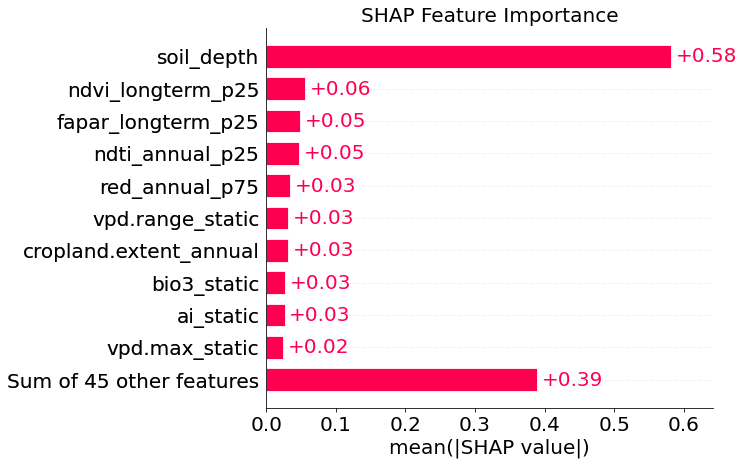

In [21]:
# Assume `shap_values` is your SHAP Explanation object
# Create the SHAP bar plot with `show=False`
shap.plots.bar(shaps, max_display=11, show=False)

# Get the current Axes object
ax = plt.gca()

# Customize the plot
ax.set_xlabel("mean(|SHAP value|)", fontsize=20)  # X-axis label size
# ax.set_ylabel("Feature", fontsize=20)  # Y-axis label size
ax.set_title("SHAP Feature Importance", fontsize=20)  # Title size

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size

for text in ax.texts:
    text.set_fontsize(20)

# Show the plot
plt.show()

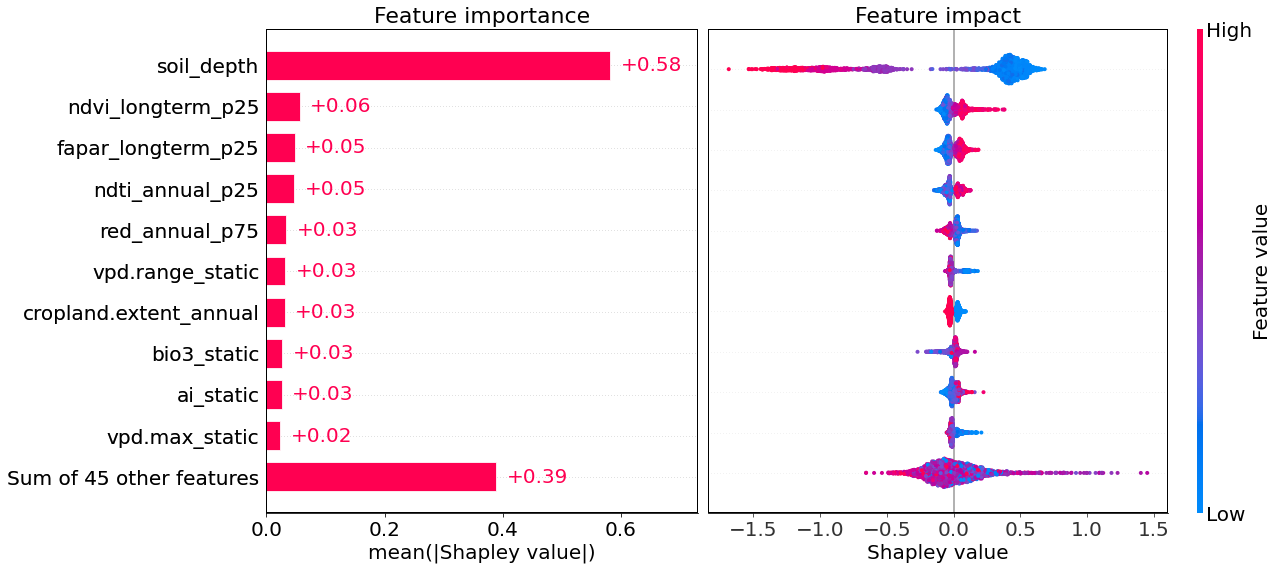

In [22]:
import shap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# Create a figure with GridSpec layout to control subplot sizes
fig = plt.figure()  # Increase figure size to be more spacious, figsize=(30, 10)
gs = GridSpec(1, 2, width_ratios=[3,4], figure=fig)  # Control the width ratios of the plots

# SHAP bar plot
ax1 = fig.add_subplot(gs[0])  # First subplot
plt.sca(ax1)  # Set the current axis to ax1
shap.plots.bar(shaps, max_display=11, show=False)

# Customize the bar plot
ax1.set_xlabel("mean(|Shapley value|)", fontsize=20)  # X-axis label size
ax1.set_title("Feature importance", fontsize=22)  # Title size
ax1.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size
ax1.set_xlim(0, 0.73)  # Set the x-axis limit to 0.6

for text in ax1.texts:
    text.set_fontsize(20)

# Add a frame (rectangle) around the bar plot
rect1 = patches.Rectangle((0, 0), 1, 1, transform=ax1.transAxes, linewidth=2, edgecolor='black', facecolor='none')
ax1.add_patch(rect1)

# SHAP beeswarm plot
ax2 = fig.add_subplot(gs[1])  # Second subplot
plt.sca(ax2)  # Set the current axis to ax2
shap.plots.beeswarm(shaps, max_display=11, show=False)

# Customize the beeswarm plot
ax2.set_xlabel("Shapley value", fontsize=20)  # X-axis label size
ax2.set_title("Feature impact", fontsize=22)  # Title size
ax2.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size
ax2.set_yticklabels([])  # Hide y-axis labels for the beeswarm plot

# Customize color bar label size if it exists
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
cbar.set_ylabel('Feature value', fontsize=20)  # Color bar label size
cbar.tick_params(labelsize=20)  # Color bar tick size

# Add a frame (rectangle) around the beeswarm plot
rect2 = patches.Rectangle((0, 0), 1, 1, transform=ax2.transAxes, linewidth=2, edgecolor='black', facecolor='none')
ax2.add_patch(rect2)

# Adjust layout manually if needed to ensure the plot takes full advantage of the figure size
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1, wspace=0.4)

# Force the layout to adjust to the new figure size
fig.set_size_inches(18, 8)  # Re-set the figure size after the plots are created
fig.tight_layout(pad=1.0)    # Apply a tight layout to avoid overlaps

# Show the combined plot
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_shap.summary.pdf', format='pdf', dpi=300)

plt.show()





### PDP

In [10]:
mean_shap_values = np.abs(shaps.values).mean(axis=0)
top_10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top_10_features = np.array(shaps.feature_names)[top_10_indices]

scaler = [1, 125, 125, 125, 1, 0.1, 1, 0.1, 1, 0.1]

top_10_features 

array(['soil_depth', 'ndvi_longterm_p25', 'fapar_longterm_p25',
       'ndti_annual_p25', 'red_annual_p75', 'vpd.range_static',
       'cropland.extent_annual', 'bio3_static', 'ai_static',
       'vpd.max_static'], dtype='<U37')

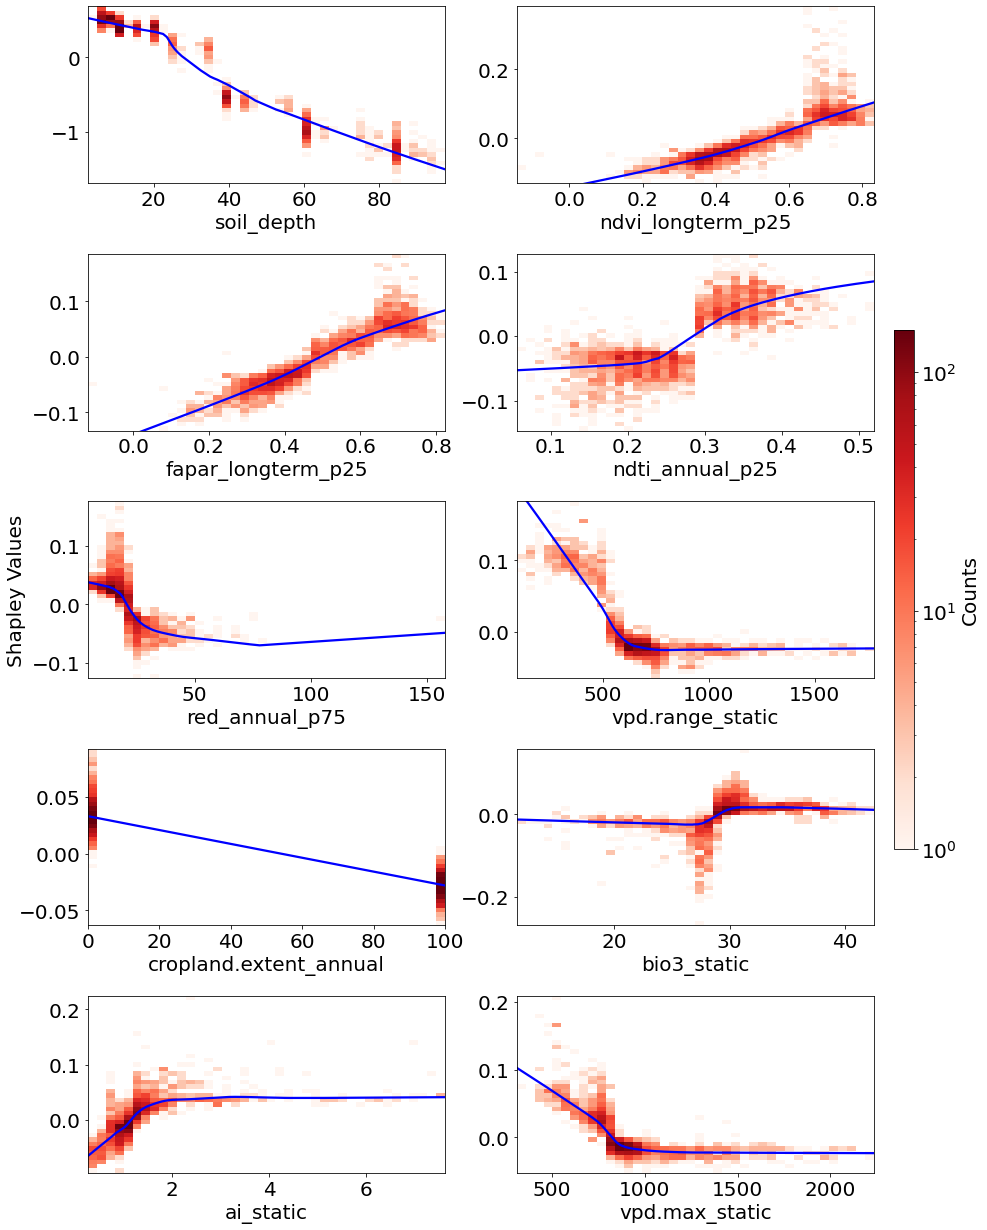

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm


# Create a figure with a grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 18))  # 5 rows, 2 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a common colormap and norm for all plots
cmap = 'Reds'
norm = LogNorm(vmin=1, vmax=150)  # Use LogNorm and set the limits to [1, 150]

# Iterate over the axes and plot each subplot
for i, feature in enumerate(top_10_features):
    ax = axes[i]
    
    # Get the feature values and corresponding SHAP values
    feature_f = rev_map.get(feature)
    feature_values = test[feature_f]
    shap_values = shaps.values[:, top_10_indices[i]]
    
    if scaler[i] == 125:
        feature_values = (feature_values/125)-1
    else:
        feature_values = feature_values*scaler[i]

    # Create a 2D histogram plot for density heatmap effect
    hist = ax.hist2d(feature_values, shap_values, bins=40, cmap=cmap, norm=norm)

    # Fit a lowess curve to show the trend (optional)
    sns.regplot(x=feature_values, y=shap_values, ax=ax, lowess=True, scatter=False, color='blue')

    # Set titles and labels with fontsize
    ax.set_xlabel(feature, fontsize=20)

    # Set tick parameters for both x and y axis
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

# Add a single shared color bar on the right side
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
cb = fig.colorbar(hist[3], cax=cbar_ax, orientation='vertical')
cb.set_label('Counts', fontsize=20)
cb.ax.tick_params(labelsize=20)

# Add a single shared y-label
fig.text(0.04, 0.5, 'Shapley Values', va='center', rotation='vertical', fontsize=20)

# Adjust the layout manually to make space for the color bar and shared y-label
plt.subplots_adjust(left=0.12, right=0.9, top=0.95, bottom=0.05, hspace=0.4)
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_shap.pdp.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()



### waterfall plot

In [27]:
test['ocd_pred'] = y_pred
test['ocd_pred_ori'] = np.expm1(test['ocd_pred'])

# sid = ['50604436', '31582170', 'RMZYIWPRXZ','2340']
sid = ['50604436','32322306'] # finland,'33702020',
water = test.loc[test['id'].isin(sid)]
mi = water.index.values
# water.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/point_waterfall.csv')
water

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,hzn_dep,texture1,texture2,texture1_qa,texture2_qa,ocd,ocd_qa,ocd_log1p,ocd_pred,ocd_pred_ori
763,32322306,42.984586,-3.393259,2018.0,LUCAS,ES,13.5,7.85,7.2,1.176,...,10.0,NaN,NaN,10.0,10.0,15.8760,10.0,2.825892,3.095895,21.107008
981,50604436,62.345592,24.321087,2018.0,LUCAS,FI,190.2,3.99,3.1,0.589,...,10.0,NaN,NaN,10.0,10.0,112.0278,10.0,4.727634,3.771049,42.425590


In [29]:
top_features = ['soil_depth', 'ndvi_longterm_p25', 'ndti_annual_p25',
       'vpd.range_static', 'fapar_longterm_p25', 'red_annual_p75',
       'cropland.extent_annual', 'bio3_static',
       'ai_static', 'vpd.max_static', 'fapar_longterm_p50','ndvi_longterm_p50']

scaler = [1, 125, 125, 0.1, 125, 1, 1, 0.1, 1, 0.1, 125, 125]

for fi in range(len(top_10_features)):
    ff = top_10_features[fi]
    orderi = shaps.feature_names.index(ff)
    vals = shaps.data[:,orderi]
    
    print(ff, scaler[fi], np.max(vals), np.min(vals))
    if scaler[fi] == 125:
        shaps.data[:,orderi] = (shaps.data[:,orderi]/125)-1
    else:
        shaps.data[:,orderi] = shaps.data[:,orderi]*scaler[fi]

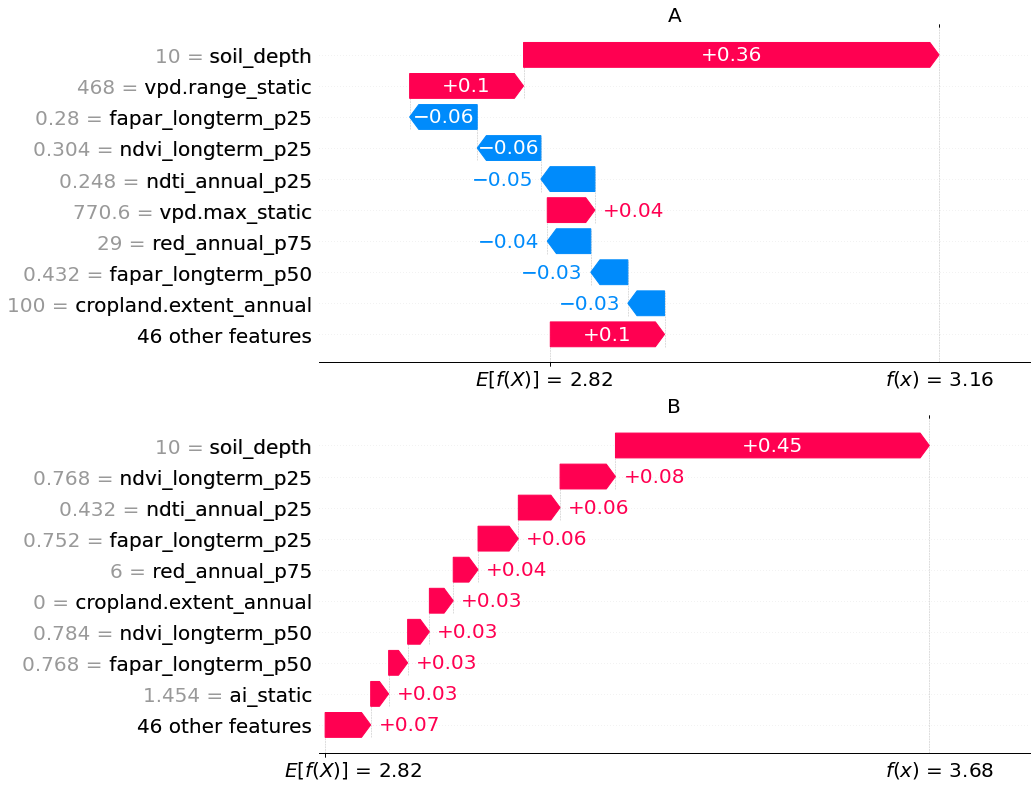

In [32]:
import shap
import matplotlib.pyplot as plt

ept = 2.81855309 #explainer.expected_value[0]
eptt = round(ept, 2)

# Create a figure with 2 subplots (vertically aligned)
fig, axes = plt.subplots(2, 1, figsize=(12, 14))  # Adjust the figsize to be larger

# Plot the first SHAP waterfall plot for idx 0
plt.sca(axes[0])  # Set the current axis to the first subplot
nuts0 = test.loc[mi[0], 'nuts0']
axes[0].set_title(f"A", fontsize=20)  # Increase title font size
shap.waterfall_plot(shap_values=shaps[mi[0]], max_display=10, show=False)

# Adjust xticklabels manually
bse = shaps[mi[0]].values.sum() + ept
bse = round(bse, 2)
axes[0].set_xticks([])  # Remove original xticks
axes[0].text(0.95, -0.05, f"$f(x)$ = {bse}", fontsize=20, ha='right', va='center', transform=axes[0].transAxes)
axes[0].text(0.22, -0.05, f"$E[f(X)]$ = {eptt}", fontsize=20, ha='left', va='center', transform=axes[0].transAxes)

for item in axes[0].get_yticklabels():
    item.set_fontsize(20)
for item in axes[0].get_xticklabels():
    item.set_fontsize(20)

for item in axes[0].get_children():
    if isinstance(item, plt.Text):
        item.set_fontsize(20)
        
# Plot the second SHAP waterfall plot for idx 1
plt.sca(axes[1])  # Set the current axis to the second subplot
nuts0 = test.loc[mi[1], 'nuts0']
axes[1].set_title(f"B", fontsize=20)  # Increase title font size
shap.waterfall_plot(shap_values=shaps[mi[1]], max_display=10, show=False)

# Adjust xticklabels manually
axes[1].set_xticks([])  # Remove original xticks
bse = shaps[mi[1]].values.sum() + ept
bse = round(bse, 2)
axes[1].text(0.95, -0.05, f"$f(x)$ = {bse}", fontsize=20, ha='right', va='center', transform=axes[1].transAxes)
axes[1].text(-0.05, -0.05, f"$E[f(X)]$ = {eptt}", fontsize=20, ha='left', va='center', transform=axes[1].transAxes)

for item in axes[1].get_yticklabels():
    item.set_fontsize(20)
for item in axes[1].get_xticklabels():
    item.set_fontsize(20)

for item in axes[1].get_children():
    if isinstance(item, plt.Text):
        item.set_fontsize(20)
        
for ax in fig.axes:
    # Increase font size for 'E[f(X)]' and its value
    for text in ax.get_xticklabels():
        if "\n$E[f(X)]$" in text.get_text() or "\n$ = " in text.get_text():
            text.set_visible(False)

    # Increase font size for 'f(x)' and its value
    for text in ax.get_xticklabels():
        if "$f(x)$" in text.get_text() or "$ = " in text.get_text():
            text.set_visible(False)
            
fig.set_size_inches(14.5, 11)  # Increase overall figure size
plt.tight_layout()
# plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_shap.waterfall.pdf', format='pdf', dpi=300)
plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_shap.waterfall.svg', format='svg', dpi=300)

plt.show()



In [260]:
np.expm1(3.16)

22.570595929068126

In [ ]:
## interaction plot
# shap_interaction_values = explainer.shap_interaction_values(test[covs])
# top10_interaction_values = shap_interaction_values[:, :10, :10]


# sample_indices = np.random.choice(test[covs].index, size=200, replace=False)
# test_sample = test[covs].iloc[sample_indices]

# shap_interaction_values = explainer.shap_interaction_values(test_sample)
# top10_interaction_values = shap_interaction_values[:, :10, :10]


In [ ]:
### individual plot
# import shap
# import matplotlib.pyplot as plt

# # Assume `shap_values` is your SHAP Explanation object
# # Create the SHAP beeswarm plot with `show=False`
# shap.plots.beeswarm(shaps, max_display=16, show=False)

# # Customize the plot
# plt.xlabel("SHAP value \n(impact on model output)", fontsize=20)  # X-axis label size
# # plt.ylabel("Feature", fontsize=20)  # Y-axis label size
# plt.xticks(fontsize=20)  # X-tick size
# plt.yticks(fontsize=20)  # Y-tick size

# # Customize color bar label size if it exists
# cbar = plt.gcf().axes[-1]  # Get the colorbar axis
# cbar.set_ylabel('Feature value', fontsize=20)  # Color bar label size
# cbar.tick_params(labelsize=20)  # Color bar tick size

# # Show the plot
# plt.show()


# import shap
# import matplotlib.pyplot as plt

# # Assume `shap_values` is your SHAP Explanation object
# # Create the SHAP bar plot with `show=False`
# shap.plots.bar(shaps, max_display=10, show=False)

# # Get the current Axes object
# ax = plt.gca()

# # Customize the plot
# ax.set_xlabel("mean(|SHAP value|)", fontsize=20)  # X-axis label size
# # ax.set_ylabel("Feature", fontsize=20)  # Y-axis label size
# ax.set_title("SHAP Feature Importance", fontsize=20)  # Title size

# # Customize tick sizes
# ax.tick_params(axis='both', which='major', labelsize=20)  # X and Y tick size

# for text in ax.texts:
#     text.set_fontsize(20)

# # Show the plot
# plt.show()

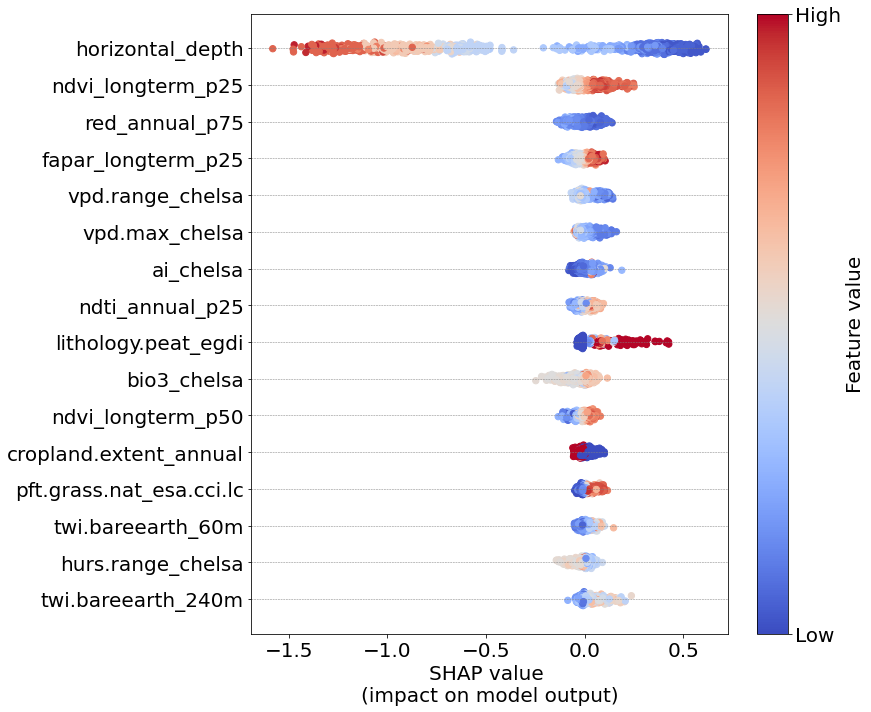

In [ ]:
# ### plot, mimic "shap.plots.bar(shaps, max_display=11)"

# # Step 1: Compute the mean absolute SHAP values for each feature
# mean_abs_shap_values = np.mean(np.abs(shaps.values), axis=0)
# feature_names = shaps.feature_names

# # Step 2: Sort the SHAP values and corresponding features
# sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Sort in descending order
# sorted_shap_values = mean_abs_shap_values[sorted_indices]
# sorted_feature_names = np.array(feature_names)[sorted_indices]

# # Step 3: Limit the number of features displayed (e.g., top 16 features)
# max_display = 16
# top_shap_values = sorted_shap_values[:max_display]
# top_feature_names = sorted_feature_names[:max_display]

# # Compute the sum of the remaining features
# sum_of_other_features = np.sum(sorted_shap_values[max_display:])
# top_shap_values = np.append(top_shap_values, sum_of_other_features)
# top_feature_names = np.append(top_feature_names, 'Sum of other features')

# # Step 4: Create a horizontal bar plot with adjustments for axis visibility and text positioning
# fig, ax = plt.subplots(figsize=(10, 9))  # Increased height for better readability

# # Set all bars to blue
# bar_color = 'royalblue'

# # Plot bars
# ax.barh(top_feature_names, top_shap_values, color=bar_color)

# # Adjust the x-limit to ensure text stays within bounds
# ax.set_xlim([0, 1.1 * max(top_shap_values)])

# # Add labels to bars with black text
# for i, value in enumerate(top_shap_values):
#     ax.text(value + 0.01, i, f'{value:.2f}', va='center', fontsize=20, color='black', zorder=5)

# # Make sure x-axis and y-axis lines are visible
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# # Set the left and bottom spines visible for axis lines
# ax.spines['left'].set_visible(True)
# ax.spines['bottom'].set_visible(True)

# # Customize the plot
# ax.set_xlabel('mean(|SHAP value|)', fontsize=20)
# # ax.set_ylabel('Feature', fontsize=20)
# ax.set_title('Top 15 important features', fontsize=22, pad=20)

# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # Reverse the order of features so that the most important feature is at the top
# ax.invert_yaxis()

# # Tight layout for better spacing
# plt.tight_layout()

# # # Save the plot as a high-resolution PDF
# # plt.savefig('custom_shap_bar_plot_v5.pdf', format='pdf', dpi=300)

# # Show plot
# plt.show()


# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# ### mimic "shap.plots.beeswarm(shaps, max_display=16, show=False)"
# # Assuming `shap_values` contains SHAP values and `X` contains the corresponding feature values
# # Extract SHAP values and feature names
# shap_values = shaps.values
# feature_names = shaps.feature_names
# X_values = shaps.data  # Assuming this holds the original feature values used in the model

# # Normalize the feature values to range [0, 1] for color mapping
# normalized_X = (X_values - np.min(X_values, axis=0)) / (np.max(X_values, axis=0) - np.min(X_values, axis=0))

# # Number of features to display
# max_display = 16
# feature_order = np.argsort(np.mean(np.abs(shap_values), axis=0))[::-1][:max_display]
# shap_values = shap_values[:, feature_order]
# normalized_X = normalized_X[:, feature_order]
# feature_names = [feature_names[i] for i in feature_order]

# # Reverse the order to show the most important features at the top
# shap_values = shap_values[:, ::-1]
# normalized_X = normalized_X[:, ::-1]
# feature_names = feature_names[::-1]

# # Create the plot
# fig, ax = plt.subplots(figsize=(12, 10))

# # Choose a color map
# cmap = plt.get_cmap("coolwarm")

# # Plot each feature
# for i, (shap_vals, feature_vals) in enumerate(zip(shap_values.T, normalized_X.T)):
#     # Create a jitter for y positions to simulate the beeswarm effect
#     y = np.random.normal(i, 0.05, size=len(shap_vals))  # Slightly reduced jitter
#     colors = cmap(feature_vals)
#     ax.scatter(shap_vals, y, color=colors, alpha=1, s=40)  # Adjusted transparency and point size
    
# # Set y-ticks to the feature names
# ax.set_yticks(np.arange(len(feature_names)))
# ax.set_yticklabels(feature_names, fontsize=20)  # Y-tick labels font size

# # Set x-label
# ax.set_xlabel("SHAP value \n(impact on model output)", fontsize=20)  # X-label font size

# # Adjust color bar to show 'Low' and 'High'
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['Low', 'High'])
# cbar.set_label("Feature value", fontsize=20)  # Colorbar label font size

# # Set the fontsize for colorbar ticks
# cbar.ax.tick_params(labelsize=20)

# # Add horizontal lines for better readability
# for i in range(len(feature_names)):
#     ax.axhline(y=i, color='grey', linestyle='--', lw=0.5)

# # Adjust tick sizes
# plt.xticks(fontsize=20)  # X-tick font size
# plt.yticks(fontsize=20)  # Y-tick font size

# plt.tight_layout()
# plt.show()

